In [1]:
import numpy as np
from kinisi.analyze import DiffusionAnalyzer
from ase.io import read
from pymatgen.io.vasp import Xdatcar
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)
rng = np.random.RandomState(42)

plt.rcParams['font.size'] = 15.5
plt.rcParams['axes.labelsize'] = 15.5
plt.rcParams['xtick.labelsize'] = 15.5
plt.rcParams['ytick.labelsize'] = 15.5
plt.rcParams['legend.fontsize'] = 15.5

In [2]:
params = {'specie': 'H',
          'time_step': 2.0,
          'step_skip': 1,
          'progress': True
          }
u_params = {'progress': True}

In [3]:
compute_msdNa_NEP = np.loadtxt("fom_data_re15ps/NEP/compute_msdNa.txt")
compute_msdNa_MLIP = np.loadtxt("fom_data_re15ps/MLIP/compute_msdNa.txt")

In [4]:
file_NEP = 'fom_data_re15ps/NEP_type/trajectory.XDATCAR'
xd_NEP = Xdatcar(file_NEP)

file_MLIP = 'fom_data_re15ps/MLIP_type/trajectory.XDATCAR'
xd_MLIP = Xdatcar(file_MLIP)

/home/yq87/miniconda3/envs/pce_env/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:265: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


In [5]:
diff_NEP = DiffusionAnalyzer.from_Xdatcar(xd_NEP, parser_params=params, uncertainty_params=u_params)
diff_MLIP = DiffusionAnalyzer.from_Xdatcar(xd_MLIP, parser_params=params, uncertainty_params=u_params)

Finding Means and Variances: 100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


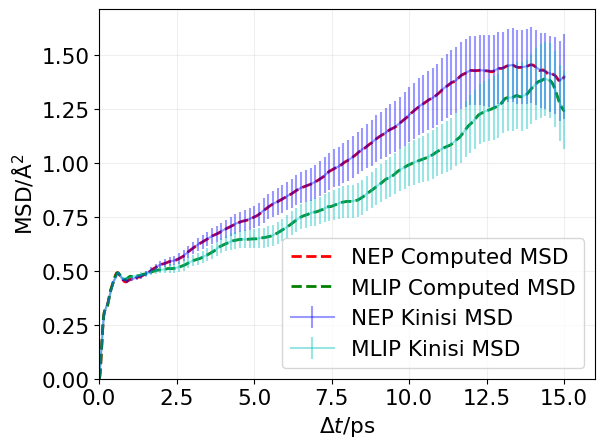

In [6]:
fig, ax = plt.subplots()
# plot computed msd
time = np.linspace(0, 15, len(compute_msdNa_NEP))
plt.plot(time, compute_msdNa_NEP, label='NEP Computed MSD', color='r', linestyle='--', linewidth=2)
plt.plot(time, compute_msdNa_MLIP, label='MLIP Computed MSD', color='g', linestyle='--', linewidth=2)

plt.errorbar(diff_NEP.dt, diff_NEP.msd, diff_NEP.msd_std, label='NEP Kinisi MSD', color='b', alpha=0.4)
plt.errorbar(diff_MLIP.dt, diff_MLIP.msd, diff_MLIP.msd_std, label='MLIP Kinisi MSD', color='c', alpha=0.4)
# plot the computed MSD
plt.ylabel('MSD/Å$^2$')
plt.xlabel(r'$\Delta t$/ps')
plt.legend(loc='lower right')
plt.grid(True, alpha = 0.2)
plt.xlim(0, 16)
plt.ylim(0, None)
# plt.show()
# save
plt.savefig('figs_15ps/MSD.png', dpi=300, bbox_inches='tight')

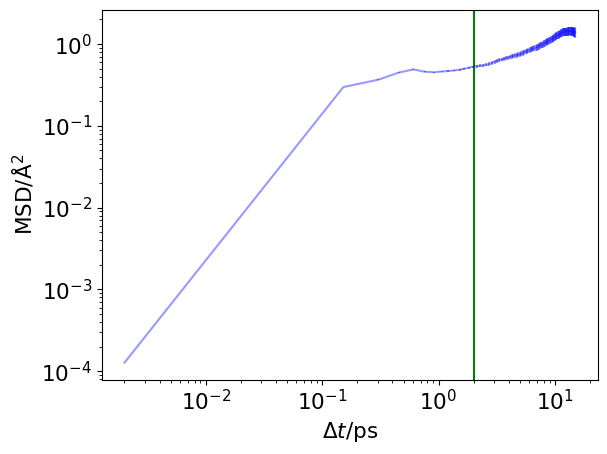

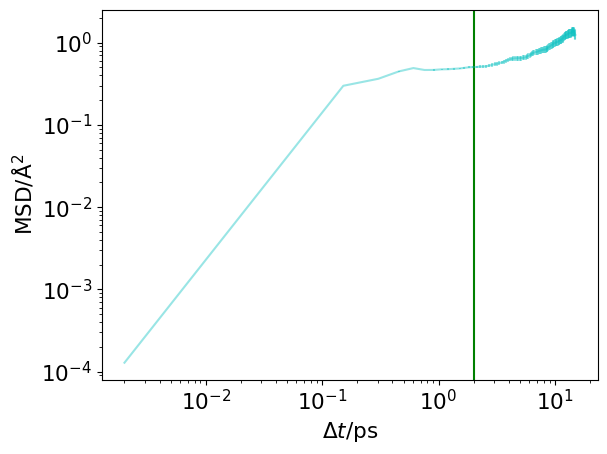

In [7]:
# NEP
fig, ax = plt.subplots()
plt.errorbar(diff_NEP.dt, diff_NEP.msd, diff_NEP.msd_std, label='NEP Kinisi MSD', color='b', alpha=0.4)
plt.axvline(2, color='g')
plt.ylabel('MSD/Å$^2$')
plt.xlabel(r'$\Delta t$/ps')
plt.yscale('log')
plt.xscale('log')
plt.show()

# MLIP
fig, ax = plt.subplots()
plt.errorbar(diff_MLIP.dt, diff_MLIP.msd, diff_MLIP.msd_std, label='MLIP Kinisi MSD', color='c', alpha=0.4)
plt.axvline(2, color='g')
plt.ylabel('MSD/Å$^2$')
plt.xlabel(r'$\Delta t$/ps')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [9]:
diff_NEP.diffusion(2, diffusion_params={'random_state': rng, 'progress': True})
diff_MLIP.diffusion(2, diffusion_params={'random_state': rng, 'progress': True})

/home/yq87/miniconda3/envs/pce_env/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
Likelihood Sampling: 100%|██████████| 1500/1500 [00:01<00:00, 1345.07it/s]
/home/yq87/miniconda3/envs/pce_env/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
Likelihood Sampling: 100%|██████████| 1500/1500 [00:01<00:00, 1361.01it/s]


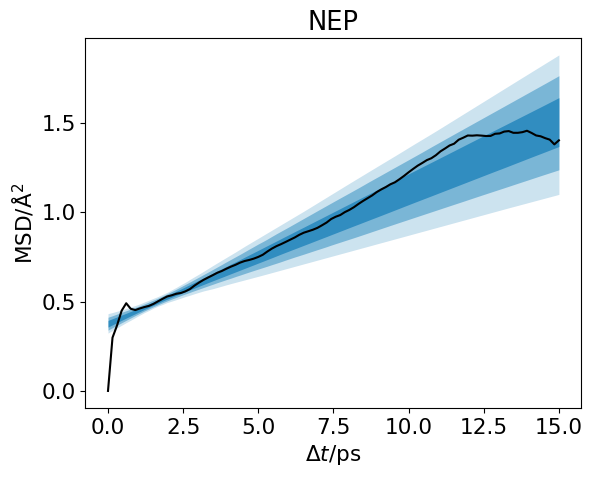

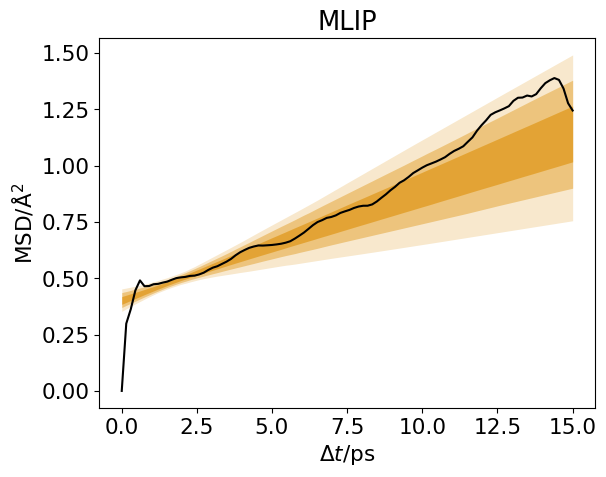

In [13]:
credible_intervals = [[16, 84], [2.5, 97.5], [0.15, 99.85]]
alpha = [0.6, 0.4, 0.2]

# NEP
plt.plot(diff_NEP.dt, diff_NEP.msd, 'k-')
for i, ci in enumerate(credible_intervals):
    plt.fill_between(diff_NEP.dt,
                     *np.percentile(diff_NEP.distribution, ci, axis=1),
                     alpha=alpha[i],
                     color='#0173B2',
                     lw=0)
plt.title('NEP')
plt.ylabel('MSD/Å$^2$')
plt.xlabel(r'$\Delta t$/ps')
plt.show()

# MLIP
plt.plot(diff_MLIP.dt, diff_MLIP.msd, 'k-')
for i, ci in enumerate(credible_intervals):
    plt.fill_between(diff_MLIP.dt,
                     *np.percentile(diff_MLIP.distribution, ci, axis=1),
                     alpha=alpha[i],
                     color='#DE8F05',
                     lw=0)
plt.title('MLIP')
plt.ylabel('MSD/Å$^2$')
plt.xlabel(r'$\Delta t$/ps')
plt.show()

NEP D:  1.2575733815548556e-06
MLIP D:  8.303333577412213e-07


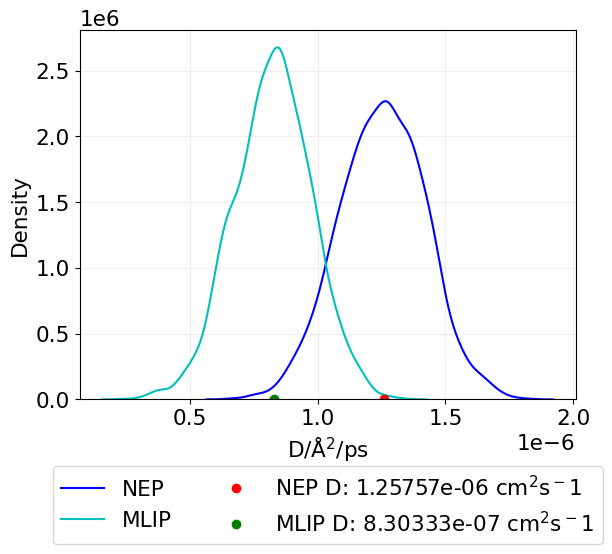

In [26]:
# density plot of the D.samples
fig, ax = plt.subplots()
sns.kdeplot(diff_NEP.D.samples, ax=ax, color='b', label='NEP')
sns.kdeplot(diff_MLIP.D.samples, ax=ax, color='c', label='MLIP')
# mark the real value
# plt.plot(diff_NEP.D.n, 0, 'ro', label=f'NEP D: {diff_NEP.D.n}')
# round to 4 significant figures
plt.plot(diff_NEP.D.n, 0, 'ro', label=rf'NEP D: {diff_NEP.D.n:.6g} cm$^2$s$^{-1}$')
print("NEP D: ", diff_NEP.D.n)
plt.plot(diff_MLIP.D.n, 0, 'go', label=rf'MLIP D: {diff_MLIP.D.n:.6g} cm$^2$s$^{-1}$')
print("MLIP D: ", diff_MLIP.D.n)
plt.grid(True, alpha = 0.2)
plt.xlabel('D/Å$^2$/ps')
plt.ylabel('Density')

# legends under plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
# plt.show()
# save
plt.savefig('figs_15ps/Density.png', dpi=300, bbox_inches='tight')

In [21]:
# plt.hist(diff.D.samples, density=True)
# plt.axvline(diff.D.n, c='k')
# plt.xlabel('$D$/cm$^2$s$^{-1}$')
# plt.ylabel('$p(D$/cm$^2$s$^{-1})$')
# plt.show()